# Notebook to create JOSS article figures

*Martin Vonk (2025)*

In [1]:
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from cycler import cycler
from matplotlib import patheffects
from scipy.stats._survival import EmpiricalDistributionFunction

import spei as si

# matplotlib settings
plt.rcParams.update(
    {
        "axes.prop_cycle": cycler(
            color=[
                "#3f90da",
                "#ffa90e",
                "#bd1f01",
                "#94a4a2",
                "#832db6",
                "#a96b59",
                "#e76300",
                "#b9ac70",
                "#717581",
                "#92dadd",
            ]
        ),
        "axes.titlesize": 7.0,
        "axes.labelsize": 7.0,
        "xtick.labelsize": 6.0,
        "ytick.labelsize": 6.0,
        "legend.fontsize": 7.0,
        "legend.framealpha": 1.0,
    }
)


def axes_indicator(
    ax: plt.Axes,
    letter: str,
    x: float,
    y: float,
    ha: Literal["left", "right"],
    va: Literal["top", "bottom"],
):
    """Add an indicator to the axes."""
    ax.annotate(
        f"({letter})",
        xy=(x, y),
        xycoords="axes fraction",
        fontsize=mpl.rcParams["axes.titlesize"],
        horizontalalignment=ha,
        verticalalignment=va,
        path_effects=[
            patheffects.Stroke(linewidth=1, foreground="white"),
            patheffects.Normal(),
        ],
    )

In [2]:
df = pd.read_csv("meteo.csv", index_col=0, parse_dates=True)
prec = df["prec"]
evap = df["evap"]
surplusd = prec - evap
surplus = surplusd.resample("MS").sum()
head = df["head"]

In [3]:
dist = sps.fisk
sispei = si.SI(
    series=surplus,
    dist=dist,
    timescale=1,
    # fit_freq="MS",
)
sispei.fit_distribution()

month = 3
ts = pd.Timestamp("2000-{:02d}-01".format(month))

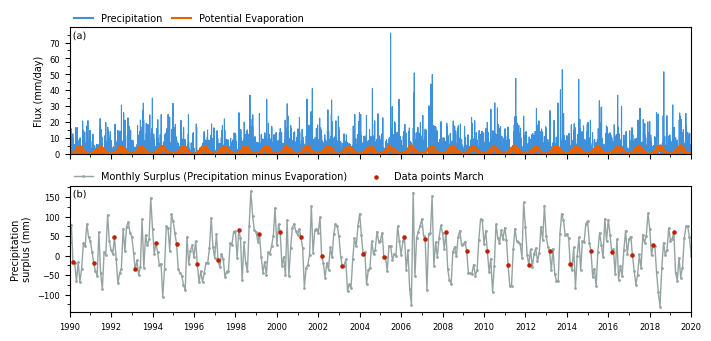

In [4]:
fig, axd = plt.subplot_mosaic(
    [["meteo"], ["sp"]], figsize=(7.0, 3.3), sharex=True, layout="constrained"
)

axd["meteo"].plot(prec.index, prec, linewidth=0.8, color="C0")
axd["meteo"].plot(evap.index, evap, linewidth=0.8, color="C6")
axd["meteo"].plot([], [], color="C0", label="Precipitation")
axd["meteo"].plot([], [], color="C6", label="Potential Evaporation")

axd["meteo"].legend(loc=(0, 1), ncol=2, frameon=False, columnspacing=1.0)
axd["meteo"].set_ylabel("Flux (mm/day)")

axd["meteo"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
axd["meteo"].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
axd["meteo"].set_ylim(bottom=0.0)
axes_indicator(axd["meteo"], letter="a", x=0.005, y=0.97, ha="left", va="top")

axd["sp"].plot(
    sispei.series.index,
    sispei.series.values,
    color="C3",
    linewidth=1.0,
    marker=".",
    markersize=2.0,
    label="Monthly Surplus (Precipitation minus Evaporation)",
)
mid = sispei.series.index.month == ts.month
axd["sp"].scatter(
    sispei.series.index[mid],  # + pd.Timedelta(days=15),
    sispei.series.values[mid],
    color="C2",
    s=5.0,
    zorder=2,
    label=f"Data points {ts.strftime('%B')}",
)
axd["sp"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
axd["sp"].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
axd["sp"].xaxis.set_minor_locator(mpl.dates.YearLocator(1))
axd["sp"].xaxis.set_major_locator(mpl.dates.YearLocator(2))
axd["sp"].set_xlim(sispei.series.index[0], sispei.series.index[-1])
axd["sp"].set_ylabel("Precipitation\nsurplus (mm)")
axd["sp"].legend(loc=(0, 1), frameon=False, ncol=2)
axes_indicator(axd["sp"], letter="b", x=0.005, y=0.97, ha="left", va="top")

axd["sp"].set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))

fig.savefig("figures/monthly_precipitation_surplus.png", dpi=300, bbox_inches="tight")

In [5]:
def plot_ecdf(
    ax: plt.Axes,
    data: pd.Series,
    ecdf: EmpiricalDistributionFunction,
    s: float,
    color: str,
    label: str,
    cdf: pd.Series | None = None,
    **kwargs,
) -> None:
    data = data.drop_duplicates()
    ax.scatter(
        data,
        ecdf.probabilities,
        s=s,
        facecolor=color,
        label=label,
        **kwargs,
    )
    if cdf is not None:
        for idata, icdf, iecdf in zip(data, cdf, ecdf.probabilities):
            ax.plot(
                [idata, idata],
                [iecdf, icdf],
                color=color,
                linewidth=0.5,
                **kwargs,
            )
    return ecdf

Data index: 1994, Data value: 31.30 CDF: 68.9%, PPF: 0.4925


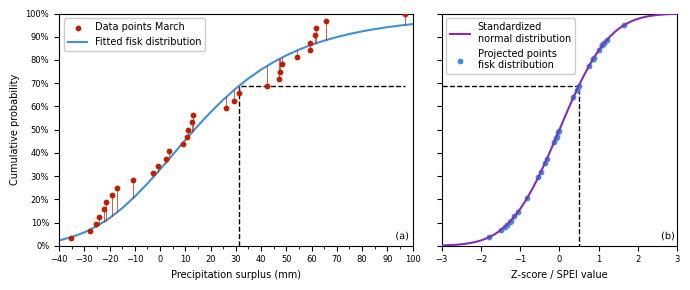

In [6]:
fit_dist = sispei._dist_dict[ts]
data = fit_dist.data.sort_values()
cdf = fit_dist.cdf().loc[data.index]
ecdf = sps.ecdf(data).cdf

zscores = np.arange(-3.0, 3.1, 0.1)
norm_cdf = sps.norm.cdf(zscores, loc=0.0, scale=1.0)
norm_cdf_transformed = sps.norm.ppf(cdf.values, loc=0.0, scale=1.0)

fig, axd = plt.subplot_mosaic(
    [["cdf", "norm"]],
    figsize=(7.0, 3),
    width_ratios=[1.5, 1.0],
    sharey=True,
    layout="tight",
)
plot_ecdf(
    ax=axd["cdf"],
    data=data,
    cdf=cdf,
    ecdf=ecdf,
    s=10.0,
    color="C2",
    label=f"Data points {ts.strftime('%B')}",
    zorder=3,
)

bin = 5.0
bins = np.arange(data.min() // bin * bin, data.max() + bin, bin)
axd["cdf"].plot(
    bins,
    fit_dist.dist.cdf(bins, *fit_dist.pars, loc=fit_dist.loc, scale=fit_dist.scale),
    label=f"Fitted {dist.name} distribution",
    color="C0",
)

axd["cdf"].legend(loc="upper left")
axd["cdf"].set_xlim(np.min(bins), np.max(bins))
axd["cdf"].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(bin))
axd["cdf"].xaxis.set_major_locator(mpl.ticker.MultipleLocator(bin * 2))
axd["cdf"].set_ylim(0.0, 1.0)
axd["cdf"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axd["cdf"].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
axd["cdf"].set_xlabel("Precipitation surplus (mm)")
axd["cdf"].set_ylabel("Cumulative probability")
axes_indicator(axd["cdf"], "a", 0.99, 0.02, ha="right", va="bottom")

axd["norm"].plot(
    zscores, norm_cdf, label="Standardized\nnormal distribution", color="C4", zorder=3
)
axd["norm"].scatter(
    norm_cdf_transformed,
    cdf.values,
    s=10.0,
    label=f"Projected points\n{dist.name} distribution",
    color="C0",
    zorder=2,
)
axd["norm"].legend(loc="upper left")
axd["norm"].set_xlim(np.min(zscores), np.max(zscores))
axd["norm"].set_xlabel("Z-score / SPEI value")

# visualize specific data point
idx = data.index[20]
cdf_idx = cdf.at[idx]
ppf_idx = sps.norm.ppf(cdf_idx)
print(
    f"Data index: {idx.strftime('%Y')}, Data value: {data.loc[idx]:0.2f} CDF: {cdf_idx:0.1%}, PPF: {ppf_idx:0.4f}"
)
axd["cdf"].plot(
    [data.loc[idx], data.loc[idx], np.max(data)],
    [0.0, cdf_idx, cdf_idx],
    color="k",
    linestyle="--",
    linewidth=1.0,
    zorder=0,
)
axd["norm"].plot(
    [np.min(zscores), ppf_idx, ppf_idx],
    [
        cdf_idx,
        cdf_idx,
        0.0,
    ],
    color="k",
    linestyle="--",
    linewidth=1.0,
    zorder=0,
)
axes_indicator(axd["norm"], "b", 0.99, 0.02, ha="right", va="bottom")

fig.savefig("figures/surplus_fit_cdf.png", dpi=300, bbox_inches="tight")

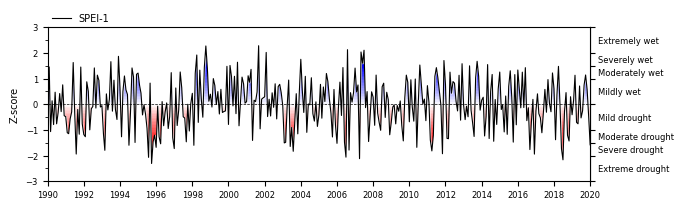

In [7]:
spei1 = sispei.norm_ppf()

ax = si.plot.si(spei1, figsize=(7.0, 2.0), layout="tight")
# ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(2))
ax.legend(labels=["SPEI-1"], loc=(0, 1), frameon=False)
ax.set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))
ax.set_ylabel("Z-score")

ax.get_figure().savefig("figures/spei1.png", dpi=300, bbox_inches="tight")

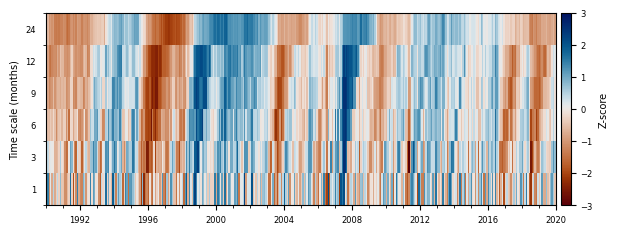

In [8]:
speis = [
    spei1.rename("1"),
    si.spei(surplus, timescale=3).rename("3"),
    si.spei(surplus, timescale=6).rename("6"),
    si.spei(surplus, timescale=9).rename("9"),
    si.spei(surplus, timescale=12).rename("12"),
    si.spei(surplus, timescale=24).rename("24"),
]
f, ax = plt.subplots(figsize=(7.0, 2.5))
si.plot.heatmap(speis, cmap="vik_r", vmin=-3, vmax=3, add_category=False, ax=ax)
ax.set_ylabel("Time scale (months)")
f.axes[-1].set_ylabel("Z-score")
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))
ax.get_figure().savefig("figures/spei_heatmap.png", dpi=300, bbox_inches="tight")

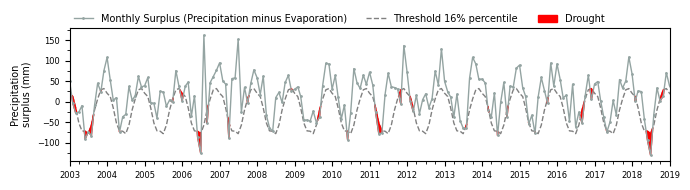

In [9]:
perc = sps.norm.cdf(-1.0)  # same as zscore -1.0
thres = sispei.ppf(perc).rename(f"Threshold {perc:0.0%} percentile")
fig, ax = plt.subplots(figsize=(7.0, 2.0), layout="tight")
ax = si.plot.threshold(
    surplus,
    thres,
    ax=ax,
    **dict(
        color="C3",
        linewidth=1.0,
        marker=".",
        markersize=2.0,
        label="Monthly Surplus (Precipitation minus Evaporation)",
    ),
)
ax.set_xlim(pd.Timestamp("2003"), pd.Timestamp("2019"))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator([4, 7, 10]))
ax.set_ylabel("Precipitation\nsurplus (mm)")
ax.legend(ncol=3, loc=(0, 1), frameon=False)
# ax.set_ylim(-150.0, 175.0)
fig.savefig("figures/threshold.png", dpi=300, bbox_inches="tight")